In [1]:
import glob
import h5py
import numpy as np 
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

from tqdm import tqdm 
from omegaconf import DictConfig, OmegaConf
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.datasets.tactile import TactileImage
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *

ModuleNotFoundError: No module named 'tactile_learning'

In [2]:
import hydra
import mmap
import numpy as np
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP

from tactile_learning.models.custom import *

def load_model(cfg, device, model_path):
    # Initialize the model
    if cfg.learner_type == 'bc':
        model = TactileJointLinear(
            input_dim=cfg.tactile_info_dim + cfg.joint_pos_dim,
            output_dim=cfg.joint_pos_dim,
            hidden_dim=cfg.hidden_dim
        )
    elif 'byol' in cfg.learner_type:
    # elif cfg.learner_type == 'tactile_byol': # load the encoder
    #     if cfg.tactile_image_size == 8:
    #         model = TactileImageEncoder(
    #             in_channels=cfg.encoder.in_channels,
    #             out_dim=cfg.encoder.out_dim
    #         )
    #     elif cfg.tactile_image_size == 16:
    #         # model = TactileLargeImageEncoder(
    #         #     in_channels=cfg.encoder.in_channels,
    #         #     out_dim=cfg.encoder.out_dim
    #         # )
    #         model = hydra.utils.instantiate(cfg.encoder) # NOTE: Wouldm't this work? 
            

    # elif cfg.learner_type == 'image_byol':
        model = hydra.utils.instantiate(cfg.encoder) # NOTE: Since here, every encoder has their own parameters inside - this is fine

    state_dict = torch.load(model_path)
    
    # Modify the state dict accordingly - this is needed when multi GPU saving was done
    new_state_dict = modify_multi_gpu_state_dict(state_dict)
    
    if 'byol' in cfg.learner_type:
        new_state_dict = modify_byol_state_dict(new_state_dict)

    # Load the new state dict to the model 
    model.load_state_dict(new_state_dict)

    # Turn it into DDP - it was saved that way 
    model = DDP(model.to(device), device_ids=[0])

    return model

In [9]:
from tactile_learning.models.pretrained import resnet18
image_out_dir = '/home/irmak/Workspace/tactile-learning/tactile_learning/out/2023.01.09/13-07_image_byol_bs_32_box_handle_lifting/box_location_changing'
device = torch.device('cuda:0')
cfg = OmegaConf.load(os.path.join(image_out_dir, '.hydra/config.yaml'))
model_path = os.path.join(image_out_dir, 'models/byol_encoder.pt')
img_encoder = load_model(cfg, device, model_path)
img_encoder.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([1, 512])

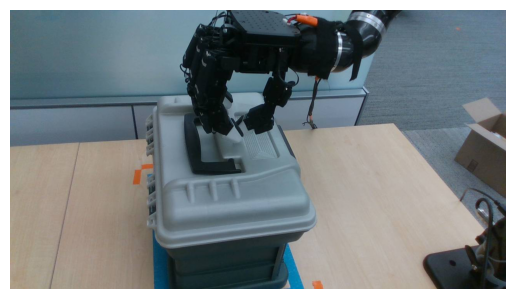

In [2]:
import cv2
import matplotlib.pyplot as plt
from holobot.utils.network import ZMQCameraSubscriber

def get_curr_img():
    image_subscriber = ZMQCameraSubscriber(
        host = '172.24.71.240',
        port = 10005,
        topic_type = 'RGB'
    )
    image, _ = image_subscriber.recv_rgb_image()
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

curr_img = get_curr_img()
# cv2.imwrite('curr_img.png', curr_img)
plt.axis('off')
plt.imshow(curr_img)


In [ ]:
from tactile_learning.utils.data import load_data
from tactile_learning.datasets.tactile_vision import crop_transform
from torchvision.datasets.folder import default_loader as loader 

class DeployVINN:
    def __init__(
        self,
        tactile_out_dir,
        image_out_dir,
        deployment_dump_dir,
        robots = ['allegro', 'kinova'],
        representation_types = ['image', 'tactile', 'kinova', 'allegro'],
        use_encoder = True,
        nn_buffer_size=100,
        nn_k=20,
        set_thumb_values=None,
        demos_to_use=[0],
        run_the_demo=False,
        sensor_indices = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14),
        allegro_finger_indices = (0,1,2,3),
        run_num=1,
    ):
        os.environ["MASTER_ADDR"] = "localhost"
        os.environ["MASTER_PORT"] = "29505"

        torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
        torch.cuda.set_device(0)

        self.sensor_indices = sensor_indices 
        self.allegro_finger_indices = [j for i in allegro_finger_indices for j in range(i*3,(i+1)*3)]
        self.use_encoder = use_encoder
        self.representation_types = representation_types
        self.set_thumb_values = set_thumb_values
        if run_the_demo:
            assert len(demos_to_use) == 1, 'While running one demo, length of the demos to use should be 1'
        self.run_the_demo = run_the_demo # Boolean to indicate if 
        self.demos_to_use = demos_to_use
        self.robots = robots # Types of robots to be used in the states

        self.tactile_cfg, self.tactile_encoder, self.tactile_transform = self._init_tactile(tactile_out_dir, 'tactile')
        self.image_cfg, self.image_encoder, self.image_transform = self._init_encoder_info(image_out_dir, 'image')

        self.data = load_data(demos_to_use) # This will return all the desired indices and the values
        self._get_all_representations()
        self.state_id = 0 # Increase it with each get_action

        self.kdl_solver = AllegroKDL()
        self.buffer = NearestNeighborBuffer(nn_buffer_size)
        self.nn_k = nn_k
        self.knn = KNearestNeighbors(
            self.all_representations, # Both the input and the output of the nearest neighbors are
            self.all_representations
        )
        self.run_num = run_num
        # self.deployment_dump_dir = os.path.join(, f'runs/run_{self.run_num}_ue_{self.use_encoder}')
        self.deployment_dump_dir = deployment_dump_dir
        os.makedirs(self.deployment_dump_dir, exist_ok=True)

    def _init_encoder_info(self, out_dir, encoder_type='tactile'): # encoder_type: either image or tactile
        cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
        model_path = os.path.join(out_dir, 'models/byol_encoder.pt')
        encoder = load_model(cfg, device, model_path)
        encoder.eval() 
        if encoder_type == 'tactile':
            transform = T.Resize(cfg.tactile_image_size, cfg.tactile_image_size))
        else:
            transform = T.Compose([
                T.Resize((480,640)),
                T.Lambda(crop_transform),
                T.ToTensor()
            ]) 

        return cfg, encoder, transform

    def _get_tactile_image(self, tactile_value):
        tactile_image = get_tactile_image(tactile_value)
        return self.tactile_transform(tactile_image)

    def _get_curr_image(self, host='172.24.71.240', port=10005)
        image_subscriber = ZMQCameraSubscriber(
            host = host,
            port = port,
            topic_type = 'RGB'
        )
        image, _ = image_subscriber.recv_rgb_image()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = self.vision_transform(image)
        return torch.FloatTensor(img)

    def _load_dataset_image(self, demo_id, image_id):
        roots = glob.glob(f'{self.image_cfg.data_dir}/demonstration_*')
        roots = sorted(roots)
        image_root = roots[demo_id]
        image_path = os.path.join(image_root, 'cam_0_rgb_images/frame_{}.png'.format(str(image_id).zfill(5)))
        img = self.vision_transform(loader(image_path))
        return torch.FloatTensor(img)

    # tactile_values: (N,16,3) - N: number of sensors
    # robot_states: { allegro: allegro_tip_positions: (3*M,) - 3 values for each finger M: number of fingers included,
    #                 kinova: kinova_states : (3,) - cartesian position of the arm end effector}
    def _get_one_representation(self, image, tactile_values, robot_states):
        for i,repr_type in enumerate(self.representation_types):
            if repr_type == 'allegro' or repr_type == 'kinova':
                new_repr = robot_states[repr_type]
            elif repr_type == 'tactile':
                if self.use_encoder: 
                    tactile_image = self._get_tactile_image(tactile_values).unsqueeze(dim=0)
                    new_repr = self.tactile_encoder(tactile_image)
                    new_repr = new_repr.detach().cpu().numpy().squeeze()
                else:
                    new_repr = tactile_values.flatten()
            elif repr_type == 'image':
                new_repr = self.image_encoder(image.unsqueeze(dim=0)) # Add a dimension to the first axis so that it could be considered as a batch
                new_repr = new_repr.detach().cpu().numpy().squeeze()

            if i == 0:
                curr_repr = new_repr 
            else: 
                curr_repr = np.concatenate(curr_repr, new_repr, axis=0)
                
        return curr_repr

    def _get_all_representations(self):  
        print('Getting all representations')
        # For each tactile value and allegro tip position 
        # get one representation and add it to all representations
        repr_dim = 0
        if 'tactile' in self.representation_types:
            if self.use_encoder:
                repr_dim = self.tactile_cfg.encoder.out_dim
            else:
                repr_dim = len(self.sensor_indices) * 16 * 3
        if 'allegro' in self.representation_types:  repr_dim += len(self.allegro_finger_indices)
        if 'kinova' in self.representation_types: repr_dim += 7
        if 'image' in self.representation_types: repr_dim += 1000 # NOTE: This should be lower (or tactile should be higher) - we could use a random layer on top?

        self.all_representations = np.zeros((
            len(self.data['tactile']['indices']), repr_dim
        ))

        print('all_representations.shape: {}'.format(self.all_representations.shape))
        pbar = tqdm(total=len(self.data['tactile']['indices']))

        for index in range(len(self.data['tactile']['indices'])):
            demo_id, tactile_id = self.data['tactile']['indices'][index]
            _, allegro_tip_id = self.data['allegro_states']['indices'][index]
            _, kinova_id = self.data['kinova']['indices'][index]
            _, image_id = self.data['image']['indices'][index]

            tactile_value = self.data['tactile']['values'][demo_id][tactile_id] # This should be (N,16,3)
            allegro_tip_position = self.data['allegro_states']['values'][demo_id][allegro_tip_id] # This should be (M*3,)
            kinova_state = self.data['kinova']['values'][demo_id][kinova_id]
            image = self._load_dataset_image(demo_id, image_id)
            
            robot_states = dict(
                allegro = allegro_tip_position,
                kinova = kinova_state
            )
            representation = self._get_one_representation(
                image,
                tactile_value, 
                robot_states
            )
            # Add only tip positions as the representation
            self.all_representations[index, :] = representation[:]
            pbar.update(1)

        pbar.close()

    def get_action(self, tactile_values, recv_robot_state, visualize=False):
        if self.run_the_demo:
            action = self._get_demo_action()
        else:
            action = self._get_knn_action(tactile_values, recv_robot_state, visualize)
        return action

    def _get_demo_action(self):
        demo_id, action_id = self.allegro_action_indices[self.state_id] 
        allegro_action = self.data['allegro_action']['values'][demo_id][action_id] # Get the next commanded action (commanded actions are saved in that timestamp)
        if self.set_thumb_values is not None:
            allegro_action[-4:] = self.set_thumb_values
        action = dict(
            allegro = allegro_action
        )
        
        if 'kinova' in self.robots:
            _, kinova_id = self.data['kinova']['indices'][self.state_id] 
            kinova_action = self.data['kinova']['values'][demo_id][kinova_id] # Get the next saved kinova_state
            action['kinova'] = kinova_action

        print(f'applying the {self.state_id}th demo action: {action}')

        self.state_id += 1

        return action

    # tactile_values.shape: (16,15,3)
    # robot_state: {allegro: allegro_joint_state (16,), kinova: kinova_cart_state (3,)}
    def _get_knn_action(self, tactile_values, recv_robot_state, visualize=False):
        # Get the allegro tip positions with kdl solver 
        allegro_joint_state = recv_robot_state['allegro']
        fingertip_positions = self.kdl_solver.get_fingertip_coords(allegro_joint_state) # - fingertip position.shape: (12)
        
        kinova_cart_state = recv_robot_state['kinova']
        curr_robot_state = dict(
            allegro = curr_fingertip_position,
            kinova = kinova_cart_state
        )

        # Get the tactile image from the tactile values
        curr_tactile_values = tactile_values[self.sensor_indices,:,:]
        curr_fingertip_position = fingertip_positions[self.allegro_finger_indices]

        # Get the current visual image
        image = self._get_curr_image()

        # Get the representation with the given tactile value
        curr_representation = self._get_one_representation(
            image,
            curr_tactile_values, 
            curr_robot_state
        )
        _, nn_idxs = self.knn.get_k_nearest_neighbors(curr_representation, k=self.nn_k)

        # Choose the action with the buffer 
        id_of_nn = self.buffer.choose(nn_idxs)
        nn_id = nn_idxs[id_of_nn]
        demo_id, action_id = self.data['allegro_actions']['indices'][nn_id] 
        print('STATE ID: {}, CHOSEN DEMO ID: {}, ACTION ID: {}'.format(self.state_id, demo_id, action_id))
        nn_allegro_action = self.data['allegro_actions']['values'][demo_id][action_id] # Get the next commanded action (commanded actions are saved in that timestamp)
        if self.set_thumb_values is not None:
            nn_allegro_action[-4:] = self.set_thumb_values
        nn_action = dict(
            allegro = nn_allegro_action
        )
        
        if 'kinova' in self.robots:
            _, kinova_id = self.data['kinova']['indices'][nn_id] 
            nn_kinova_action = self.data['kinova']['values'][demo_id][kinova_id] # Get the next saved kinova_state
            nn_action['kinova'] = nn_kinova_action

        # Visualize if given 
        if visualize: # TODO: This should be fixed for the whole robot
            self._visualize_state(
                curr_tactile_values, 
                curr_fingertip_position,
                kinova_cart_state[:3],
                nn_id
            )

        self.state_id += 1

        return nn_action

    def _visualize_state(self, curr_tactile_values, curr_fingertip_position, curr_kinova_cart_pos, nn_id):
        demo_id, tactile_id = self.data['tactile']['indices'][nn_id]
        _, allegro_tip_id = self.data['allegro']['indices'][nn_id]
        _, kinova_id = self.kinova_indices[nn_id]

        knn_tactile_values = self.tactile_values[demo_id][tactile_id]
        knn_tip_pos = self.allegro_tip_positions[demo_id][allegro_tip_id]
        knn_cart_pos = self.kinova_states[demo_id][kinova_id][:3]

        # Dump all the current state, nn state and curr image
        dump_camera_image()
        dump_whole_state(curr_tactile_values, curr_fingertip_position, curr_kinova_cart_pos, title='curr_state')
        dump_whole_state(knn_tactile_values, knn_tip_pos, knn_cart_pos, title='knn_state')

        # Plot from the dumped images
        dump_knn_state(
            dump_dir = self.deployment_dump_dir,
            img_name = 'state_{}.png'.format(str(self.state_id).zfill(2))
        ) # It will read the written images

In [55]:
# Helper script to load models
import numpy as np
import os
import torch
import torch.utils.data as data 
import torchvision.transforms as T

from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP

from holobot.robot.allegro.allegro_kdl import AllegroKDL
from tactile_learning.models.custom import TactileJointLinear, TactileImageEncoder

def load_model(cfg, device, model_path):
    # Initialize the model
    if cfg.agent_type == 'bc':
        model = TactileJointLinear(
            input_dim=cfg.tactile_info_dim + cfg.joint_pos_dim,
            output_dim=cfg.joint_pos_dim,
            hidden_dim=cfg.hidden_dim
        )
    elif cfg.agent_type == 'byol': # load the encoder
        model = TactileImageEncoder(
            in_channels=cfg.encoder.in_channels,
            out_dim=cfg.encoder.out_dim
        )
    # print('model: {}'.format(model))
    state_dict = torch.load(model_path)
    
    # Modify the state dict accordingly - this is needed when multi GPU saving was done
    new_state_dict = modify_multi_gpu_state_dict(state_dict)
    
    if cfg.agent_type == 'byol':
        new_state_dict = modify_byol_state_dict(new_state_dict)

    # Load the new state dict to the model 
    model.load_state_dict(new_state_dict)

    # Turn it into DDP - it was saved that way 
    model = DDP(model.to(device), device_ids=[0])

    return model

def modify_multi_gpu_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v 
    return new_state_dict

def modify_byol_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'encoder.net' in k:
            name = k[12:] # Everything after encoder.net
            new_state_dict[name] = v
    # print(new_state_dict['encoder.net'])
    return new_state_dict


In [13]:
out_dir = '/home/irmak/Workspace/tactile-learning/tactile_learning/out/2023.01.02/19-29_byol_bs_1028_box_handle_lifting'
vinn = DeployVINN(out_dir)

self.allegro_finger_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
self.only_states: False, self.use_encoder: True
Getting all representations
all_representations.shape: (72266, 79)


100%|██████████| 72266/72266 [00:43<00:00, 1660.80it/s]
/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/ikpy/chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))
/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/ikpy/chain.py:60: UserWarning: Link joint_3.0_tip (index: 5) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any tra

In [14]:
x = np.random.rand(15,16,3)
allegro_joint_states = np.random.rand(16)
kinova_cart_states = np.random.rand(3)
robot_state = dict(
    allegro = allegro_joint_states,
    kinova = kinova_cart_states
)

In [15]:
action = vinn.get_action(x, robot_state)

curr_tactile_values.shape: (15, 16, 3), curr_fingertip_position.shape: (12,), curr_kinova_state.shape: (3,)
nn_idxs: [37896 37897 37895 37894 37901 14827 14829 14828 15566 15567 35652 14832
 14831 14830 35659 35657 35658 35661 35660 35654]
chosen nn_id: 37896
kinova action shape: (3,)
nn_action: {'allegro': array([ 0.        , -0.17453294,  0.7853982 ,  0.7853982 ,  0.        ,
       -0.17453294,  0.7853982 ,  0.7853982 ,  0.08726646, -0.08726646,
        0.87266463,  0.7853982 ,  1.0471976 ,  0.43633232,  0.2617994 ,
        0.7853982 ], dtype=float32), 'kinova': array([-1.19047608,  0.01418956, -0.3219771 ,  0.        ,  0.        ,
        0.        ])}
